In [8]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden - Stable Diffusion XL 1.0 - TPU v5e


## Overview

This notebook demonstrates how to deploy the [stabilityai/stable-diffusion-xl-base-1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0) model on Vertex AI for online prediction.

## Before you begin

**NOTE**: 

*  Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.
*  This Notebook demonstrate how to deploy the model [stabilityai/stable-diffusion-xl-base-1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0) on Vertex AI prediction endpoint with a TPU v5e instance (machine type of `ct5lp-hightpu-1t`). Please ensure you have enough resource quota in region `us-west1`. If not, please follow the [instructions](https://cloud.google.com/vertex-ai/docs/predictions/use-tpu#securing_capacity) to get quota.

### Setup notebook

#### Colab
Run the following commands for Colab.

In [9]:
if "google.colab" in str(get_ipython()):
    ! pip3 install --upgrade google-cloud-aiplatform
    from google.colab import auth as google_auth

    google_auth.authenticate_user()

# Restart the notebook kernel after installs.
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### Setup Google Cloud project

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API and Compute Engine API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component).

1. [Create a Cloud Storage bucket](https://cloud.google.com/storage/docs/creating-buckets) for storing experiment outputs.

1. [Create a service account](https://cloud.google.com/iam/docs/service-accounts-create#iam-service-accounts-create-console) with `Vertex AI User` and `Storage Object Admin` roles for deploying models to Vertex AI endpoint.

Set following variables for experiments environment:

In [1]:
# The service account for deploying fine tuned model.
SERVICE_ACCOUNT = "255766800726-compute@developer.gserviceaccount.com"  # @param {type:"string"}


UNIQUE_PREFIX = "sd"
# Cloud project id.
PROJECT_IDS = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_IDS[0]  # @param {type:"string"}

# The Cloud Storage bucket for storing experiments output.
# Remove prefix gs://, e.g. foo_bucket.
GCS_BUCKET_LOCATION = REGION =  'us-west1' #"us-central1"

PROJECT_ID_PREFIX = PROJECT_ID #[:-8]
GCS_BUCKET = GCS_BUCKET_URI = f"gs://{PROJECT_ID_PREFIX}-{UNIQUE_PREFIX}"

# print variables for verification
print(f"Project ID: {PROJECT_ID}")
print(f"GCS Bucket URI: {GCS_BUCKET_URI}")

Project ID: my-project-0004-346516
GCS Bucket URI: gs://my-project-0004-346516-sd


Initialize Vertex AI API:

In [2]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=GCS_BUCKET)

### Define constants

In [3]:
# The pre-built serving docker image. It contains serving scripts and models.
SERVE_DOCKER_URI = "us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/jax-diffusers-serve-tpu:20240110_1526_RC00"

### Define common functions

In [4]:
import base64
from io import BytesIO

from google.cloud import aiplatform
from PIL import Image


def base64_to_image(image_str):
    """Convert base64 encoded string to an image."""
    image = Image.open(BytesIO(base64.b64decode(image_str)))
    return image


def image_grid(imgs, rows=2, cols=2):
    w, h = imgs[0].size
    grid = Image.new(
        mode="RGB", size=(cols * w + 10 * cols, rows * h), color=(255, 255, 255)
    )
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w + 10 * i, i // cols * h))
    return grid


def deploy_model(model_id):
    """Create a Vertex AI Endpoint and deploy the specified model to the endpoint."""
    model_name = model_id + "-tpu"
    endpoint = aiplatform.Endpoint.create(display_name=f"{model_name}-endpoint")

    model = aiplatform.Model.upload(
        display_name=model_name,
        serving_container_image_uri=SERVE_DOCKER_URI,
        serving_container_ports=[8080],
        serving_container_predict_route="/predict",
        serving_container_health_route="/health",
    )
    machine_type = "ct5lp-hightpu-1t"

    model.deploy(
        endpoint=endpoint,
        machine_type=machine_type,
        deploy_request_timeout=1800,
        service_account=SERVICE_ACCOUNT,
        enable_access_logging=True,
        min_replica_count=1,
        sync=True,
        system_labels={
            "NOTEBOOK_NAME": "model_garden_jax_stable_diffusion_xl.ipynb"
        },
    )
    return model, endpoint

## Upload and Deploy models

This section uploads the model to Model Registry and deploys it to a Vertex AI Endpoint resource.

The model deployment step will take ~30 minutes to complete.

### Text-to-image

Deploy the stable diffusion xl model for the text-to-image task.

Once deployed, you can send a batch of text prompts to the endpoint to generated images.

When deployed on one TPU V5e instance, the averaged inference time of one image is ~3 seconds.

In [5]:
# Set the model_id to "stabilityai/stable-diffusion-xl-base-1.0" to load the OSS pre-trained model.
model, endpoint = deploy_model(
    model_id="stabilityai/japanese-stable-diffusion-xl",
)

Creating Endpoint
Create Endpoint backing LRO: projects/255766800726/locations/us-west1/endpoints/4465402593421557760/operations/5427199840062799872
Endpoint created. Resource name: projects/255766800726/locations/us-west1/endpoints/4465402593421557760
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/255766800726/locations/us-west1/endpoints/4465402593421557760')
Creating Model
Create Model backing LRO: projects/255766800726/locations/us-west1/models/2170211652857757696/operations/4526479914588700672
Model created. Resource name: projects/255766800726/locations/us-west1/models/2170211652857757696@1
To use this Model in another session:
model = aiplatform.Model('projects/255766800726/locations/us-west1/models/2170211652857757696@1')
Deploying model to Endpoint : projects/255766800726/locations/us-west1/endpoints/4465402593421557760
Deploy Endpoint model backing LRO: projects/255766800726/locations/us-west1/endpoints/4465402593421557760/operations/1795046

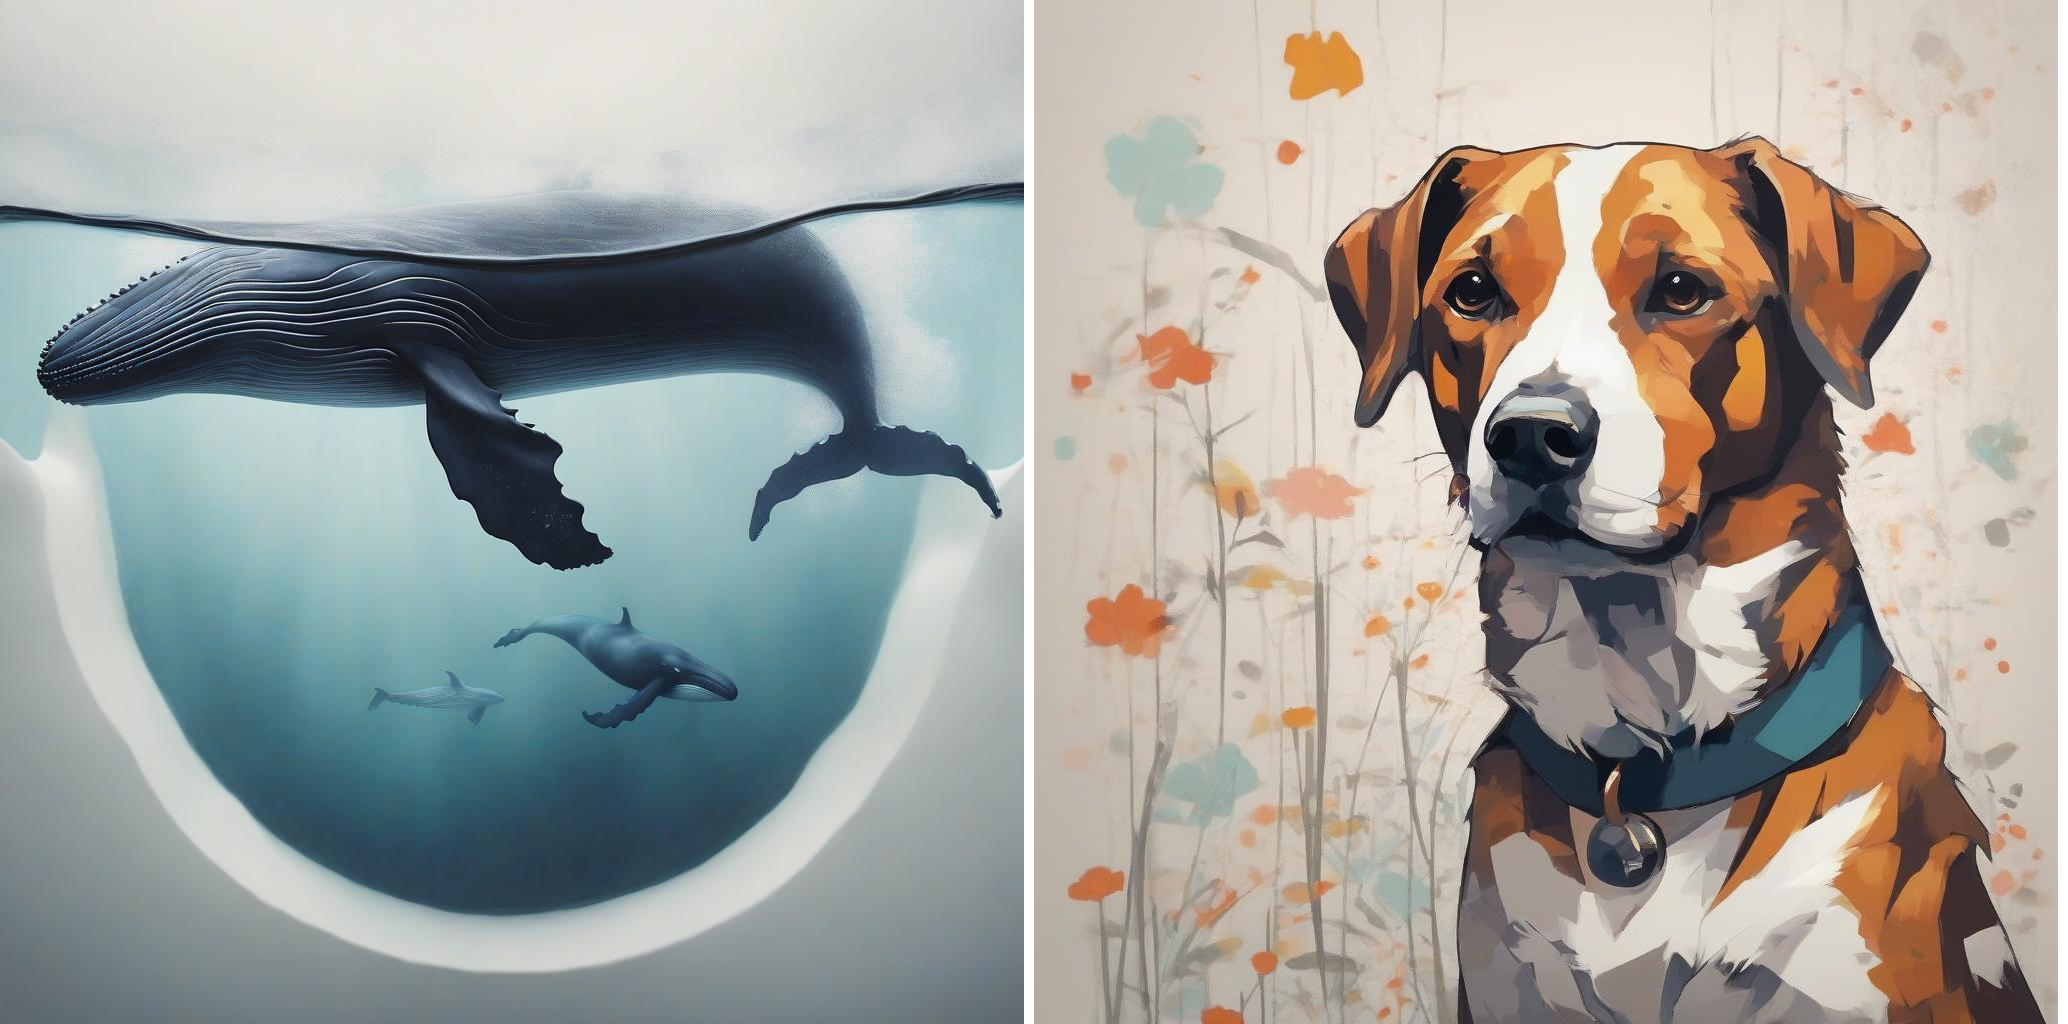

In [6]:
instances = [
    {
        "prompt": "Photorealistic whale swimming in abyss",
        "height": 1024,
        "width": 1024,
    },
    {
        "prompt": "柴犬、カラフルアート",
        "height": 1024,
        "width": 1024,
    },
]
response = endpoint.predict(instances=instances)

images = [
    base64_to_image(prediction.get("images")[0]) for prediction in response.predictions
]
image_grid(images, rows=1)

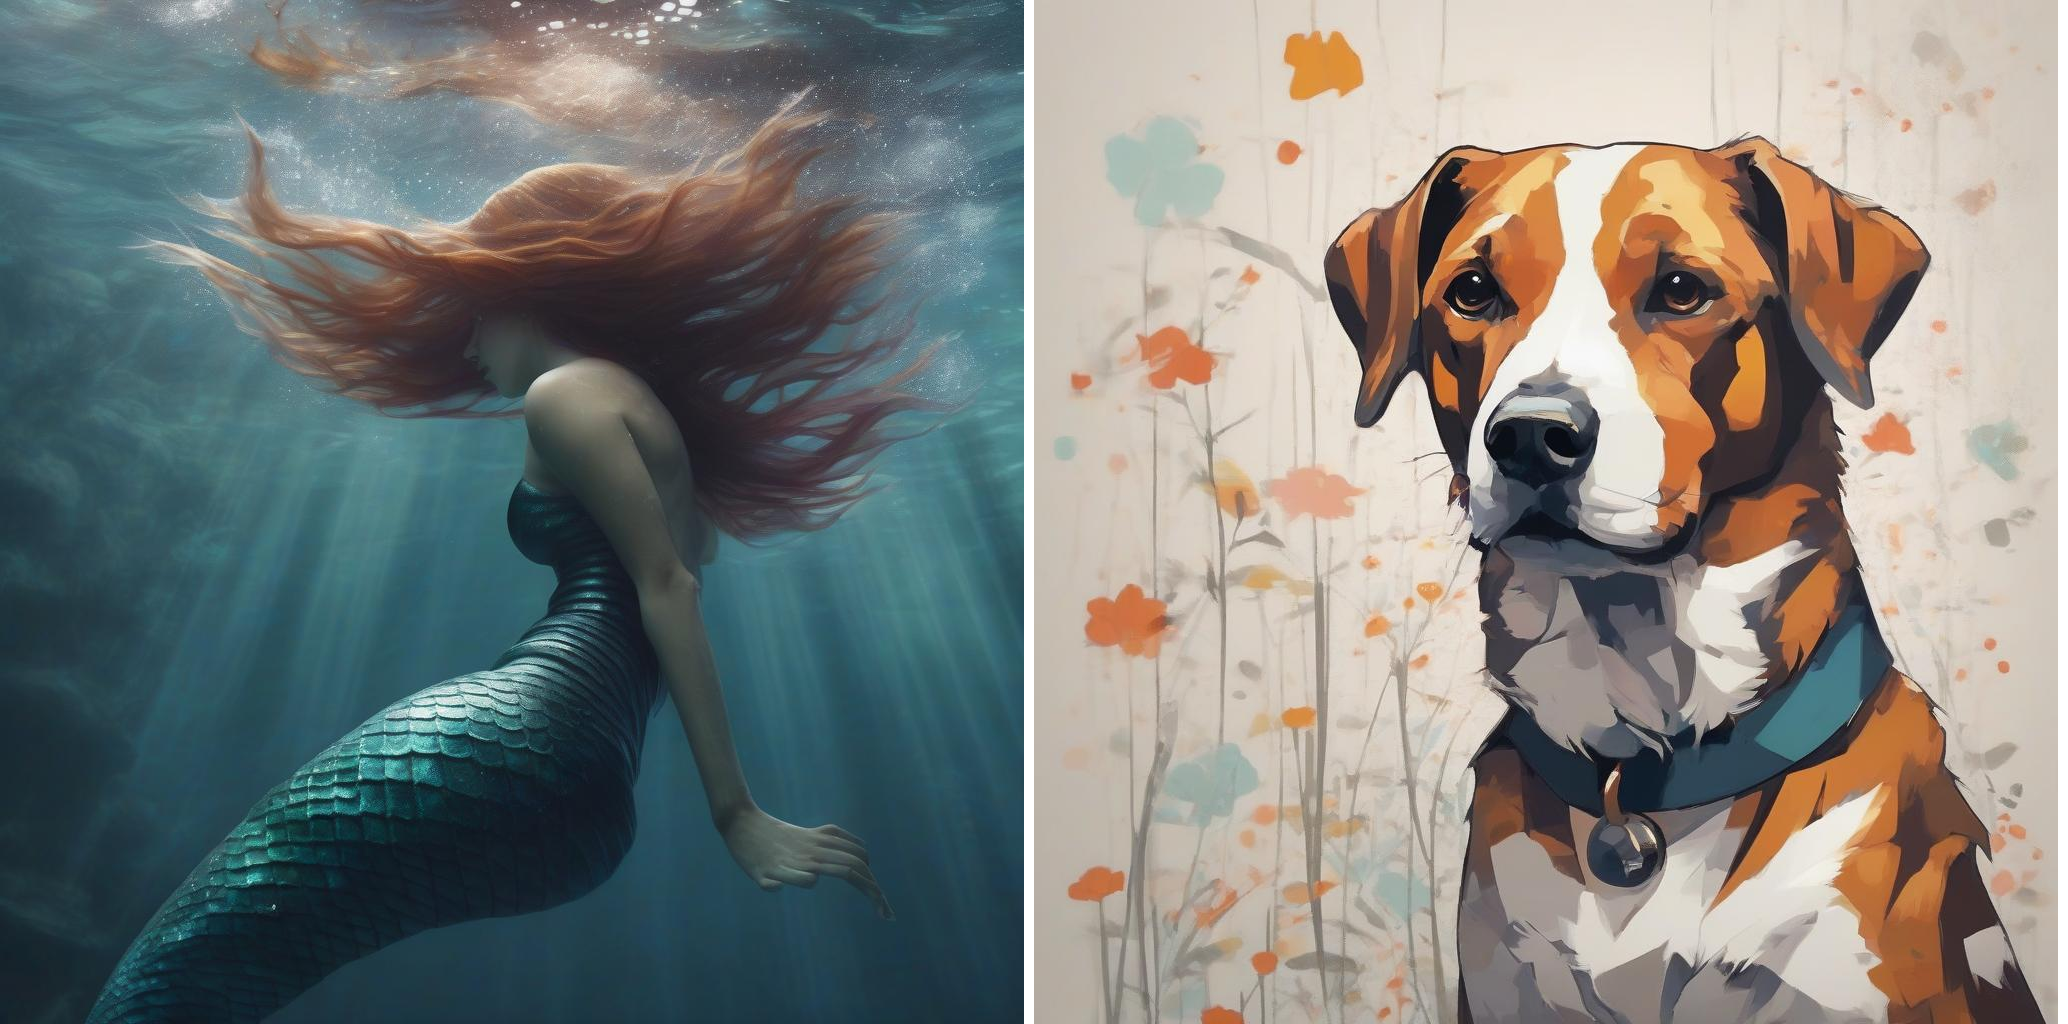

In [9]:
instances = [
    {
        "prompt": "Photorealistic mermaid swimming in abyss",
        "height": 1024,
        "width": 1024,
    },
    {
        "prompt": "「春の京都で、満開の桜の下、抹茶と桜餅を楽しむ舞妓さん。",
        "height": 1024,
        "width": 1024,
    },
]
response = endpoint.predict(instances=instances)

images = [
    base64_to_image(prediction.get("images")[0]) for prediction in response.predictions
]
image_grid(images, rows=1)

### Clean up resources:

In [8]:
# Undeploy model and delete endpoint.
# endpoint.delete(force=True)

# # Delete models.
# model.delete()